In [4]:
from preprocess import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
import matplotlib.pyplot as plt

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
config_max_len = 11
config_buckets = 20

save_data_to_array(max_len=config_max_len, n_mfcc=config_buckets)

labels=["bed", "happy", "cat"]

Saving vectors of label - 'happy': 100%|██████████| 1743/1743 [00:15<00:00, 115.55it/s]


In [9]:
temp = np.load("bed.npy")
temp.shape

(1713, 20, 11)

In [8]:
# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

In [14]:
X_train[0].shape

(20, 11)

In [15]:
# # Feature dimension
channels = 1
batch_size = 100

num_classes = 3

X_train = X_train.reshape(X_train.shape[0], config_buckets, config_max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config_buckets, config_max_len, channels)

In [16]:
X_train[0].shape

(20, 11, 1)

0.0


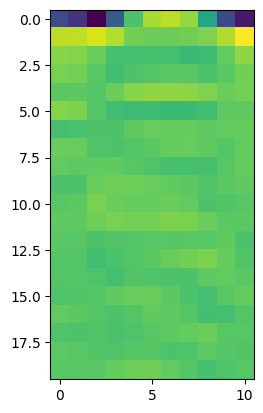

In [17]:
plt.imshow(X_train[110, :, :, 0])
print(y_train[110])

In [18]:
y_train_hot = tf.keras.utils.to_categorical(y_train)
y_test_hot = tf.keras.utils.to_categorical(y_test)

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.95:                 
            print("\n Reached 95 percent accuracy so cancelling training!")
            self.model.stop_training = True 

In [20]:
callbacks = myCallback()

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(config_buckets, config_max_len, channels)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 192)               0

In [24]:
history = model.fit(X_train, y_train_hot, epochs=115, validation_data=(X_test, y_test_hot), callbacks=[callbacks])

Epoch 1/115
114/114 [==============================] - 6s 7ms/step - loss: 1.2352 - accuracy: 0.3365 - val_loss: 1.0768 - val_accuracy: 0.4181
Epoch 2/115
114/114 [==============================] - 1s 5ms/step - loss: 1.0367 - accuracy: 0.4441 - val_loss: 0.7627 - val_accuracy: 0.6712
Epoch 3/115
114/114 [==============================] - 1s 5ms/step - loss: 0.7079 - accuracy: 0.6999 - val_loss: 0.5011 - val_accuracy: 0.8163
Epoch 4/115
114/114 [==============================] - 1s 5ms/step - loss: 0.5417 - accuracy: 0.7987 - val_loss: 0.4409 - val_accuracy: 0.8420
Epoch 5/115
114/114 [==============================] - 1s 5ms/step - loss: 0.4425 - accuracy: 0.8436 - val_loss: 0.3437 - val_accuracy: 0.8767
Epoch 6/115
114/114 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.8590 - val_loss: 0.2725 - val_accuracy: 0.9069
Epoch 7/115
114/114 [==============================] - 1s 5ms/step - loss: 0.3794 - accuracy: 0.8634 - val_loss: 0.3570 - val_accuracy: 0.8664

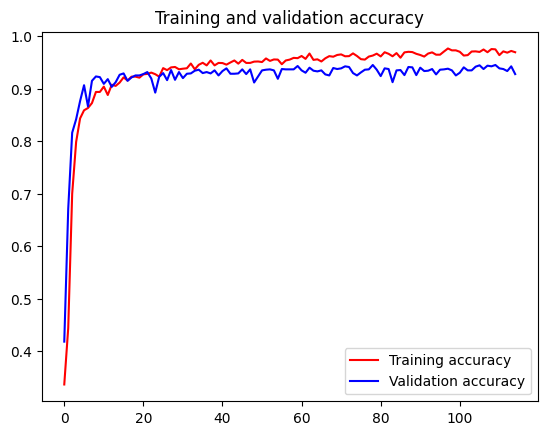

<Figure size 640x480 with 0 Axes>

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [41]:
import sounddevice as sd
import librosa
import soundfile as sf

duration = 1  # recording duration in seconds
fs = 16000  # sample rate

print("Recording started...")
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # wait until recording is finished

sf.write("test.wav", recording, fs)

print(f"Recording saved as test.wav")
audio_file = "test.wav"


Recording started...
Recording saved as test.wav


In [42]:
mfcc = wav2mfcc(audio_file, n_mfcc=20, max_len=11)

np.save('./audio.npy', mfcc)

In [43]:
X = np.load('audio.npy')
X_Final = X.reshape((-1, config_buckets, config_max_len, channels))
X.shape

(20, 11)

In [44]:
val = model.predict(X_Final)
reversed_labels = np.argmax(val, axis=1)

if reversed_labels[0] == 0:
    print("You spoke: BED")
elif reversed_labels[0] == 1:
    print("You spoke: CAT")
elif reversed_labels[0] == 2:
    print("You spoke: HAPPY")

1/1 [==============================] - 0s 30ms/step
You spoke: CAT
